# Домашнее задание. Классификация изображений

* Необходимо классифицировать персонажей из всеми любимого сериала Симпсоны, которому уже больше 30 лет!



In [1]:
#SCORE на Kaggle: 0.98

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

### Установка зависимостей

In [8]:
'''
           НИК НА Kaggle: Макар_Косенко_355913931
'''
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [5]:
pip install googl

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nose-1.3.7-py3-none-any.whl.metadata (1.7 kB)
INFO: pip is looking at multiple versions of specloud to determine which version is compatible with other requirements. This could take a while.
  Installing build dependencies ... done
  Getting requirements to build whe

In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

ModuleNotFoundError: No module named 'google'

In [4]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

unzip:  cannot find or open /content/gdrive/MyDrive/journey-springfield.zip, /content/gdrive/MyDrive/journey-springfield.zip.zip or /content/gdrive/MyDrive/journey-springfield.zip.ZIP.


In [8]:
!ls train

ls: cannot access 'train': No such file or directory


In [10]:
!ls journey-springfield

characters_illustration.png  sample_submission.csv  testset  train


In [6]:
!ls data

ls: cannot access 'data': No such file or directory


In [7]:
!ls data/train

ls: cannot access 'data/train': No such file or directory


In [7]:
!nvidia-smi
import torch
torch.cuda.is_available()

zsh:1: command not found: nvidia-smi


False

In [13]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [15]:
# это пакет для проверки версий других пакетов
import pkg_resources

In [8]:
!python --version

Python 3.11.12


In [3]:
for b in ['torch', 'torchvision', 'tqdm', 'matplotlib', 'seaborn', 'Pillow']:
    print(b + ' version: '+ pkg_resources.get_distribution(b).version)

torch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124
tqdm version: 4.67.1
matplotlib version: 3.7.5
seaborn version: 0.12.2
Pillow version: 11.1.0


#### Версии питона и библиотек, на которых работал эталонный ноутбук:

Python 3.11.11

torch version: 2.5.1+cu124

torchvision version: 0.20.1+cu124

tqdm version: 4.67.1

matplotlib version: 3.10.0

seaborn version: 0.13.2

Pillow version: 11.1.0


In [16]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

Полезная статья, которой мы вдохновились при создании класса `SimpsonsDataset`:

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

`ToTensor` конвертирует  `PIL Image` с параметрами в диапазоне $[0, 255]$ (как все пиксели) в `FloatTensor` размера ($C \times H \times W$) $[0,1]$ , затем производится масштабирование:
$\text{input} = \frac{\text{input} - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размеру (это делает метод  _prepare_sample).

In [17]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который подгружает их из папок,
    производит скалирование и превращение в тензоры PyTorch.
    """
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        # Осуществляем аугментацию данных для искусственного увеличения количества данных
        self.train_transforms = transforms.Compose([
            transforms.RandomChoice([
                transforms.Compose([
                    transforms.Resize(300),
                    transforms.CenterCrop(300),
                ]),
                transforms.RandomRotation(degrees=(-25, 25)),
                transforms.RandomHorizontalFlip(p=0.7),
            ]),
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

        self.test_val_transforms = transforms.Compose([
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])


        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            self.classes = list(self.label_encoder.classes_)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file).convert("RGB")  # .convert для надёжности
        image.load()
        return image

    def __getitem__(self, index):
        image = self.load_sample(self.files[index])

        if self.mode == 'train':
            image = self.train_transforms(image)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return image, y
            
        elif self.mode == 'val':
            image = self.test_val_transforms(image)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return image, y

        else:
            image = self.test_val_transforms(image)
            #label = self.labels[index]
            #label_id = self.label_encoder.transform([label])
            #y = label_id.item()
            return image #, y

In [18]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [19]:
from pathlib import Path

# Пути для Kaggle
TRAIN_DIR = Path("/kaggle/input/journey-springfield/train/simpsons_dataset")  # если внутри train есть simpsons_dataset
TEST_DIR = Path("/kaggle/input/journey-springfield/testset")

# Если структура плоская (без simpsons_dataset внутри train):
# TRAIN_DIR = Path("/kaggle/input/journey-springfield/train")

In [20]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [21]:
print(TRAIN_DIR)
!ls $TRAIN_DIR


/kaggle/input/journey-springfield/train/simpsons_dataset
abraham_grampa_simpson	  groundskeeper_willie	ned_flanders
agnes_skinner		  homer_simpson		nelson_muntz
apu_nahasapeemapetilon	  kent_brockman		otto_mann
barney_gumble		  krusty_the_clown	patty_bouvier
bart_simpson		  lenny_leonard		principal_skinner
carl_carlson		  lionel_hutz		professor_john_frink
charles_montgomery_burns  lisa_simpson		rainier_wolfcastle
chief_wiggum		  maggie_simpson	ralph_wiggum
cletus_spuckler		  marge_simpson		selma_bouvier
comic_book_guy		  martin_prince		sideshow_bob
disco_stu		  mayor_quimby		sideshow_mel
edna_krabappel		  milhouse_van_houten	snake_jailbird
fat_tony		  miss_hoover		troy_mcclure
gil			  moe_szyslak		waylon_smithers


In [22]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [24]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [25]:
train_val_dataset = SimpsonsDataset(train_val_files, mode='train')

In [26]:
print("Train size:", len(train_val_dataset))
print("Val size:", len(val_dataset))


Train size: 20933
Val size: 5234


In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

**!** Обратите внимание, что возможно, датасет требует дополнительной фильтрации, так как лейблы не всегда точно соответствуют картинкам.

In [27]:
from collections import Counter

# Извлекаем имена папок (то есть классы)
train_val_labels = [path.parent.name for path in train_val_files]

# Считаем количество каждого класса
label_counts = Counter(train_val_labels)

# Красиво выводим
for label, count in label_counts.items():
    print(f"{label}: {count} изображений")


abraham_grampa_simpson: 913 изображений
agnes_skinner: 42 изображений
apu_nahasapeemapetilon: 623 изображений
barney_gumble: 106 изображений
bart_simpson: 1342 изображений
carl_carlson: 98 изображений
charles_montgomery_burns: 1193 изображений
chief_wiggum: 986 изображений
cletus_spuckler: 47 изображений
comic_book_guy: 469 изображений
disco_stu: 8 изображений
edna_krabappel: 457 изображений
fat_tony: 27 изображений
gil: 27 изображений
groundskeeper_willie: 121 изображений
homer_simpson: 2246 изображений
kent_brockman: 498 изображений
krusty_the_clown: 1206 изображений
lenny_leonard: 310 изображений
lionel_hutz: 3 изображений
lisa_simpson: 1354 изображений
maggie_simpson: 128 изображений
marge_simpson: 1291 изображений
martin_prince: 71 изображений
mayor_quimby: 246 изображений
milhouse_van_houten: 1079 изображений
miss_hoover: 17 изображений
moe_szyslak: 1452 изображений
ned_flanders: 1454 изображений
nelson_muntz: 358 изображений
otto_mann: 32 изображений
patty_bouvier: 72 изображени

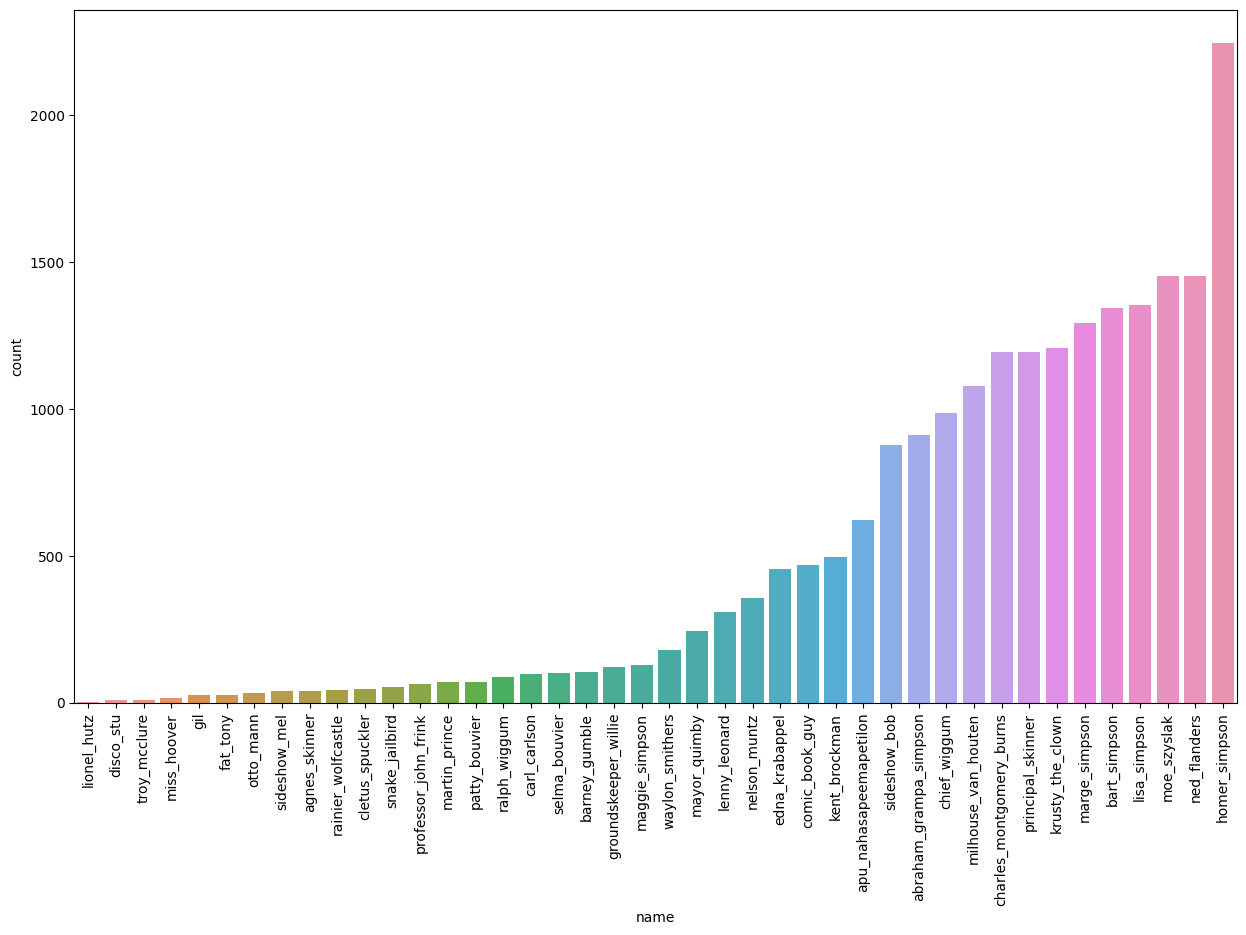

In [30]:
import pandas as pd
import seaborn as sns
def get_count(labels):
    df = pd.DataFrame(labels, columns=['name'])
    df['count'] = 1
    return df.groupby('name').count().sort_values('count')

data = get_count(train_val_labels)
def show_data(data):
    plt.figure(figsize=(15, 9))
    sns.barplot(x=data.index, y=data['count'], orient='v').set_xticklabels(data.index, rotation=90)

    plt.show()
show_data(data)

In [32]:
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter

def create_dataloader(dataset, mode, batch_size, num_workers):
    """
    Создаёт DataLoader с балансировкой классов (для train) или обычный (для val/test)
    """
    if mode == "train":
        # Подсчитываем количество примеров каждого класса
        class_counts = Counter(dataset.labels)

        # Вычисляем вес каждого класса: чем реже, тем выше вес
        class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

        # Присваиваем каждому элементу вес в зависимости от его класса
        sample_weights = [class_weights[label] for label in dataset.labels]

        # Число выборок: max * num_classes
        N = max(class_counts.values()) * len(class_counts)

        train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)

        return DataLoader(dataset, batch_size = batch_size, sampler=train_sampler, num_workers = num_workers)

    else:
        return DataLoader(dataset, batch_size=batch_size, num_workers = num_workers, shuffle=False)


In [33]:
train_loader = create_dataloader(train_val_dataset, mode="train", batch_size=256, num_workers=4)
val_loader = create_dataloader(train_val_dataset, mode = "val", batch_size = 256, num_workers = 4)

In [34]:
count = Counter()
for data, labels in train_loader:
    count += Counter(labels.tolist())
print(sum(count.values()), count)        #теперь выборка содержит 94 тысячи обьекта

94332 Counter({33: 2345, 23: 2312, 4: 2309, 3: 2307, 27: 2296, 5: 2287, 7: 2285, 18: 2285, 13: 2279, 22: 2275, 38: 2272, 2: 2268, 28: 2265, 29: 2259, 15: 2259, 40: 2253, 8: 2252, 6: 2252, 9: 2251, 24: 2250, 39: 2249, 36: 2243, 0: 2238, 10: 2234, 41: 2234, 1: 2232, 35: 2232, 12: 2228, 37: 2228, 17: 2226, 20: 2226, 19: 2224, 34: 2219, 26: 2219, 25: 2213, 30: 2206, 32: 2205, 21: 2198, 11: 2189, 31: 2180, 16: 2177, 14: 2171})


Давайте посмотрим на наших героев внутри датасета.

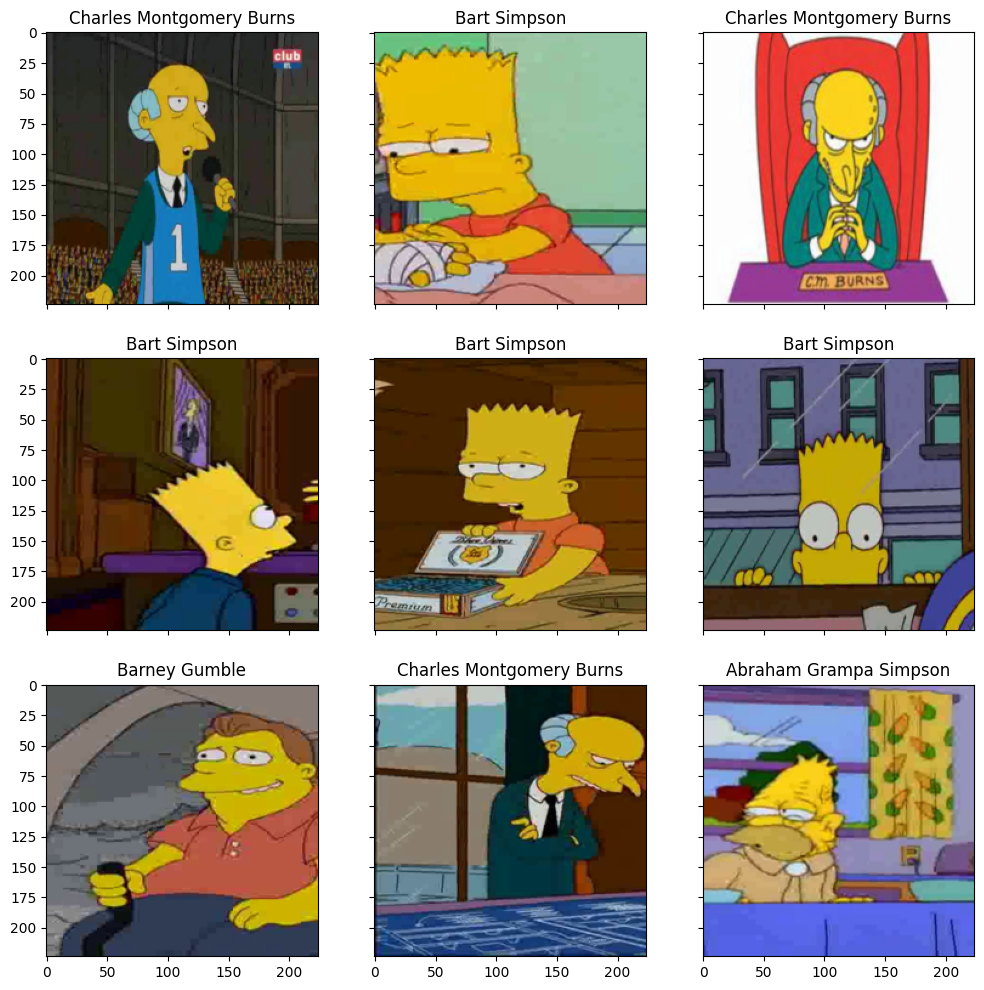

In [35]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

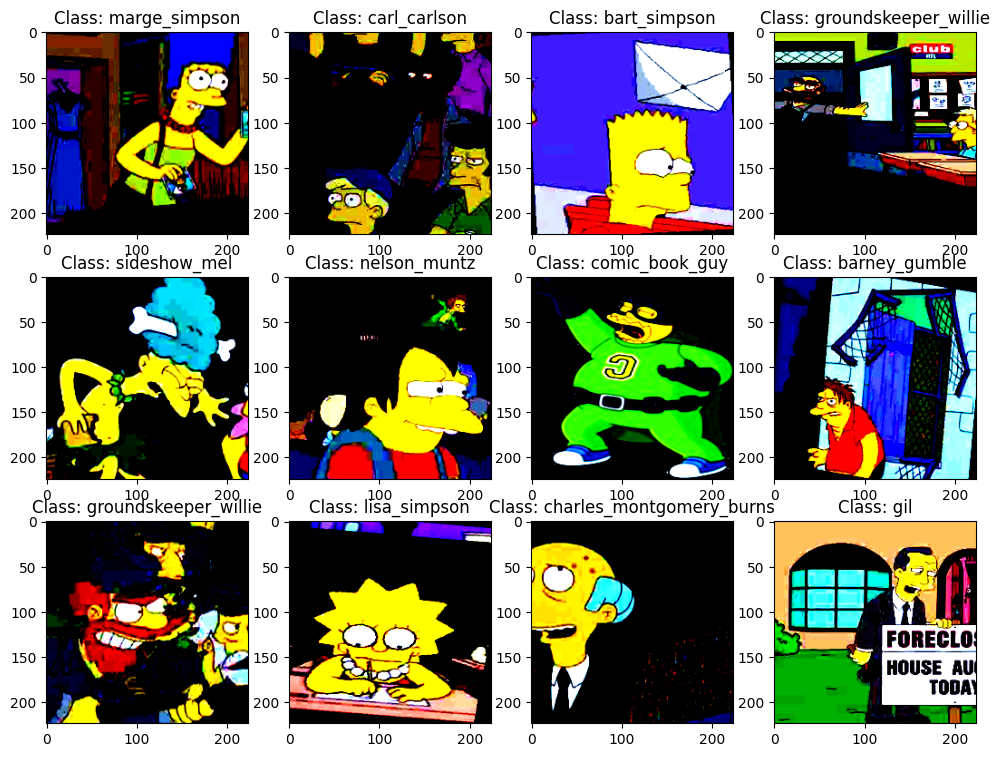

In [36]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Рисуем примеры аугментированных картинок
axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))[1]
data, labels = next(iter(train_loader))


for ax, d, l in zip(axes.flatten(), data, labels):
    ax.imshow(d.permute(1, 2, 0))  
    class_name = train_val_dataset.label_encoder.inverse_transform([l.item()])[0] 
    ax.set_title(f"Class: {class_name}")

plt.show()

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle.

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: $3\times 224 \times 224$
2.размерности после слоя:  $8 \times 111 \times 111$
3. $16 \times 54 \times 54$
4. $32 \times 26 \times 26$
5. $64 \times 12 \times 12$
6. выход: $96 \times 5 \times 5$

О том, как работают свёртки подробней можно прочитать в документации Pytorch на функцию `Conv2d`:

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

Калькулятор свёрток:

https://madebyollin.github.io/convnet-calculator/

#### Модель

In [39]:
class SimpleCnn(nn.Module):
    """
    Очень простая сверточная нейронная сеть для классификации изображений.

    Эта сеть состоит из пяти сверточных слоев, каждый из которых
    включает в себя операцию свертки, функцию активации ReLU и операцию
    пулинга (max-pooling). На выходе используется полносвязный слой
    для классификации на заданное количество классов.

    Параметры:
    ----------
    n_classes : int
        Количество классов для классификации.

    Примечание:
    ----------
    Входные изображения должны иметь размерность (3, H, W), где
    3 - слои rgb для цветной картинки, а H и W - высота и ширина изображения,
    соответственно. Размер выходного тензора будет равен (n_classes).

    Методы:
    -------
    forward(x):
        Пропускает входные данные через сеть и возвращает логиты для
        каждого класса.
    """

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=4704, out_features=1024),  # 96 * 7 * 7 = 4704, 7 а не 5 из-за паддинга
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(in_features=1024, out_features=n_classes)
        )
        # self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

#### Функция обучения:

In [40]:
def fit_epoch(model, train_loader, criterion, optimizer):
    """
    Функция обучает модель на одной эпохе, используя предоставленный dataloader.

    Эта функция проходит по всем данным в `train_loader`, выполняет шаг моделью (forward),
    вычисляет лосс, выполняет обратное распространение с помощью заданного
    оптимизатора и обновляет веса модели.
    В конце эпохи возвращаются средний лосс и
    точность на обучающем наборе данных.

    Параметры:
    ----------
    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    train_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных и
        соответствующих меток. Должен возвращать кортежи (inputs, labels).

    criterion : nn.Module
        Функция потерь, используемая для вычисления ошибки между
        предсказаниями модели и истинными метками.

    optimizer : torch.optim.Optimizer
        Оптимизатор, используемый для обновления весов модели на основе
        градиентов, вычисленных в процессе обучения.

    Функция возвращает:
    ----------
    tuple
        Кортеж, содержащий средний лосс (train_loss) и точность (train_acc)
        на обучающем наборе данных за текущую эпоху.
    """

    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

#### Функция валидации:

In [41]:
def eval_epoch(model, val_loader, criterion):
    """
    Функция оценивает работу модели на валидационном наборе данных за одну эпоху.

    Эта функция проходит по всем данным в `val_loader`, выполняет прямое
    распространение, вычисляет лосс и точность модели. В конце эпохи
    возвращаются средний лосс и точность на валидационном наборе данных.

    Параметры:
    ----------
    model : nn.Module
        Модель, которую необходимо оценить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    val_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных и
        соответствующих меток для валидации. Должен возвращать кортежи
        (inputs, labels).

    criterion : nn.Module
        Функция потерь, используемая для вычисления ошибки между
        предсказаниями модели и истинными метками.

    Функция возвращает:
    ----------
    tuple
        Кортеж, содержащий среднюю потерю (val_loss) и точность (val_acc)
        на валидационном наборе данных за текущую эпоху.
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

#### Полный цикл обучения

In [42]:
def train(train_loader, model, epochs, batch_size):
    """
    Функция обучает модель на обучающем наборе данных и оценивает ее на валидационном наборе данных.

    Эта функция создает загрузчики данных для обучающего и валидационного наборов,
    а затем выполняет обучение модели в течение заданного количества эпох.
    В конце каждой эпохи выводятся значения потерь и точности для обучающего и
    валидационного наборов. История обучения сохраняется и возвращается.

    Параметры:
    ----------
    train_files : list
        Список файлов или путей к файлам, содержащим обучающие данные.

    val_files : list
        Список файлов или путей к файлам, содержащим валидационные данные.

    model : nn.Module
        Модель, которую необходимо обучить. Должна быть экземпляром класса
        PyTorch `nn.Module`.

    epochs : int
        Количество эпох для обучения модели.

    batch_size : int
        Размер батча, используемый для загрузки данных.

    Возвращает:
    ----------
    list
        Список, содержащий кортежи (train_loss, train_acc, val_loss, val_acc)
        для каждой эпохи, где:
        - train_loss: средняя потеря на обучающем наборе.
        - train_acc: точность на обучающем наборе.
        - val_loss: средняя потеря на валидационном наборе.
        - val_acc: точность на валидационном наборе.
    """


    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

#### Применение модели к данным

In [44]:
def predict(model, test_loader):
    """
    Функция выполняет предсказание классов для тестового набора данных с использованием обученной модели.

    Эта функция принимает модель и загрузчик тестовых данных, применяет модель к
    изображениям и возвращает вероятности предсказанных классов.

    Параметры:
    ----------
    model : nn.Module
        Обученная модель, которая будет использоваться для предсказания.
        Должна быть экземпляром класса PyTorch `nn.Module`.

    test_loader : DataLoader
        Загрузчик данных, который предоставляет батчи входных данных для тестирования.
        Должен возвращать тензоры входных данных.

    Возвращает:
    ----------
    numpy.ndarray
        Массив вероятностей предсказанных классов для каждого примера в тестовом наборе.
        Размерность массива будет (N, C), где N - количество примеров, а C - количество классов.
    """

    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [45]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

Запустим обучение сети.

In [47]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [48]:
num_epochs = 10

In [49]:
history = train(train_loader, model=simple_cnn, epochs=10, batch_size=256)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.3046500480825076


epoch:  10%|█         | 1/10 [04:38<41:48, 278.73s/it]


Epoch 001 train_loss: 1.3047     val_loss 0.9969 train_acc 0.6731 val_acc 0.7199
loss 0.346777629468503


epoch:  20%|██        | 2/10 [09:19<37:21, 280.16s/it]


Epoch 002 train_loss: 0.3468     val_loss 0.4896 train_acc 0.9049 val_acc 0.8582
loss 0.1640135626686275


epoch:  30%|███       | 3/10 [14:01<32:47, 281.04s/it]


Epoch 003 train_loss: 0.1640     val_loss 0.3238 train_acc 0.9543 val_acc 0.9050
loss 0.11197505583070047


epoch:  40%|████      | 4/10 [18:41<28:01, 280.26s/it]


Epoch 004 train_loss: 0.1120     val_loss 0.2382 train_acc 0.9673 val_acc 0.9272
loss 0.08603714474604865


epoch:  50%|█████     | 5/10 [23:19<23:17, 279.43s/it]


Epoch 005 train_loss: 0.0860     val_loss 0.1571 train_acc 0.9746 val_acc 0.9531
loss 0.06633360937941632


epoch:  60%|██████    | 6/10 [27:54<18:32, 278.07s/it]


Epoch 006 train_loss: 0.0663     val_loss 0.1402 train_acc 0.9805 val_acc 0.9573
loss 0.05932383885994059


epoch:  70%|███████   | 7/10 [32:41<14:03, 281.14s/it]


Epoch 007 train_loss: 0.0593     val_loss 0.1231 train_acc 0.9824 val_acc 0.9622
loss 0.05016743480915628


epoch:  80%|████████  | 8/10 [37:15<09:17, 278.87s/it]


Epoch 008 train_loss: 0.0502     val_loss 0.1163 train_acc 0.9851 val_acc 0.9661
loss 0.04055399367453009


epoch:  90%|█████████ | 9/10 [42:08<04:43, 283.05s/it]


Epoch 009 train_loss: 0.0406     val_loss 0.1390 train_acc 0.9879 val_acc 0.9593
loss 0.04519481115289273


epoch: 100%|██████████| 10/10 [46:50<00:00, 281.02s/it]


Epoch 010 train_loss: 0.0452     val_loss 0.0905 train_acc 0.9867 val_acc 0.9729


Построим кривые обучения

In [50]:
loss, acc, val_loss, val_acc = zip(*history)

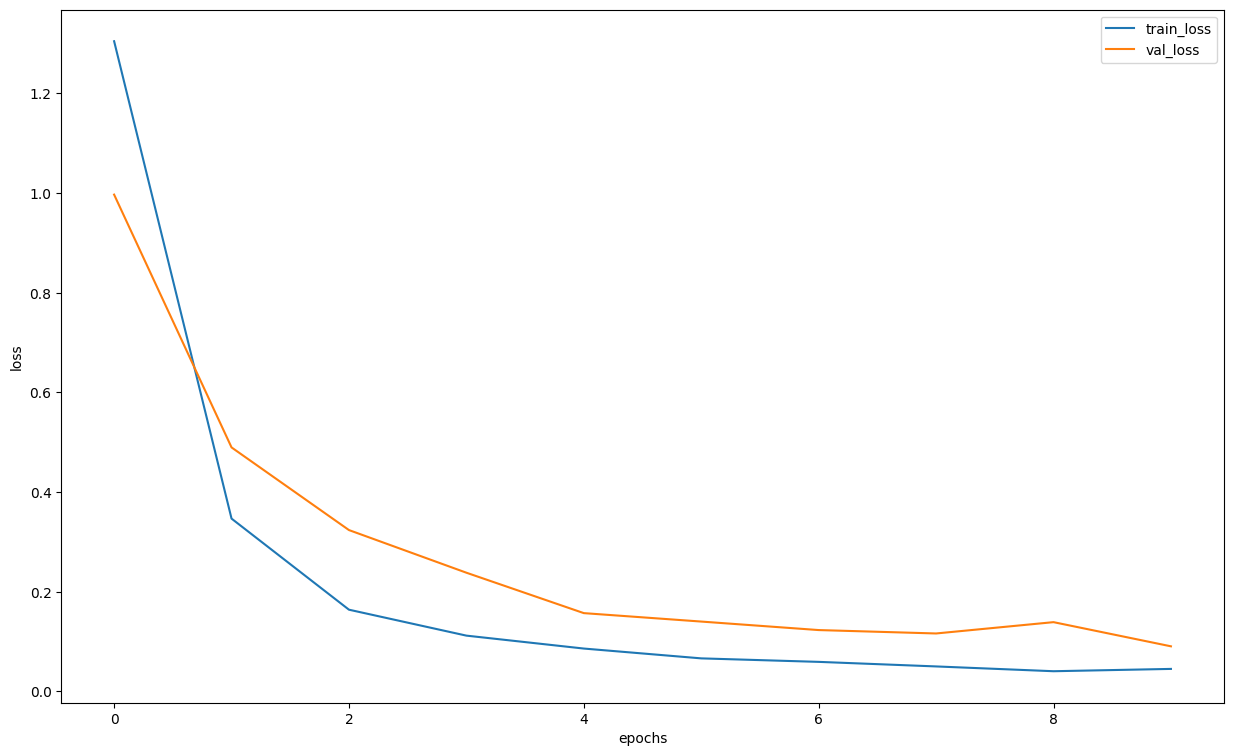

In [51]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит `softmax`, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [53]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [54]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [55]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [57]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [58]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе -- `f1-score`.

Вычислим целевую метрику на валидационной выборке.

In [59]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)

F1-оценка: 1.0


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

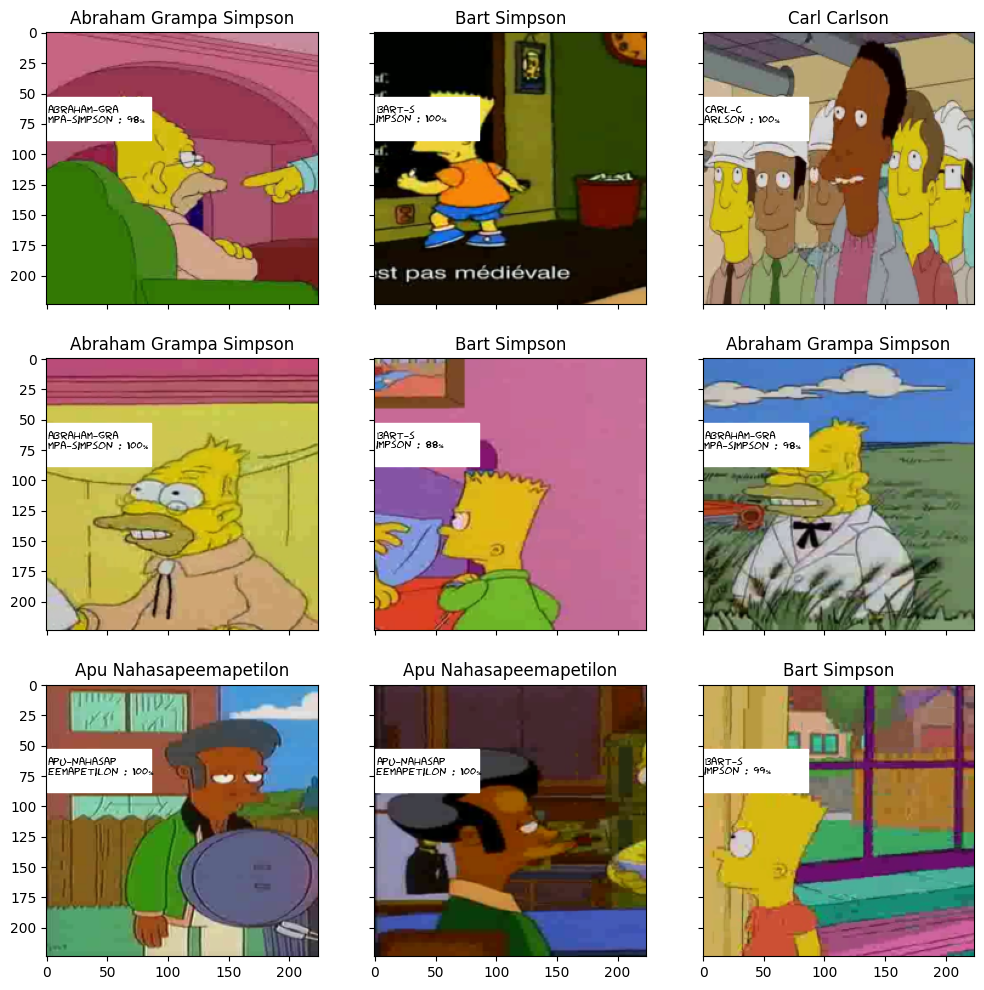

In [60]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [61]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)

preds = [train_dataset.classes[i] for i in probs.argmax(axis=-1)]
#preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [62]:
test_filenames_and_preds = list(zip(test_filenames, preds))

In [63]:
test_filenames_sort = sorted(test_filenames_and_preds, key=lambda x: int(x[0][3:-4]))

In [65]:
new_test_filenames = [i[0] for i in test_filenames_sort]
new_preds = [i[1] for i in test_filenames_sort]

In [69]:
import pandas as pd
#my_submit = pd.read_csv("/content/sample_submission.csv")
my_submit = pd.DataFrame({'Id': new_test_filenames, 'Expected': new_preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img2.jpg,mayor_quimby
3,img3.jpg,nelson_muntz
4,img4.jpg,lisa_simpson


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [70]:
my_submit.to_csv('bуest_cnn_baseline.csv', index=False)

In [ ]:
print("cv")